# **Kaggle Challenge: Pirate Pain Dataset 🏴‍☠️ (v2: K-Fold Ensemble)**

This notebook implements a robust K-Fold Cross-Validation and Ensembling strategy to improve on the baseline model. 

**Strategy:**
1.  **Hyperparameter Search:** Use Ray Tune & Optuna on a single 80/20 split to find a good set of hyperparameters (the `FINAL_CONFIG`).
2.  **K-Fold Training:** Instead of training one model on 100% of the data, we train `K` (e.g., 5) models on `K` different 80/20 splits ("folds"). We use early stopping to find the best model for each fold and save it to disk.
3.  **Ensemble Prediction:** To create the final submission, we load all `K` models. We get `K` different predictions for the test set, average their (softmax) probabilities, and then aggregate these averaged probabilities for the final submission. This is far more robust than training a single, "blind" model.

## ⚙️ **1. Setup & Libraries**

In [22]:
# Set seed for reproducibility
SEED = 123

# Import necessary libraries
import os
import logging
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import copy
from itertools import product
import time

# Set environment variables before importing modules
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# --- PyTorch Imports ---
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

# --- Sklearn Imports ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# --- Ray[tune] & Optuna Imports ---
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from functools import partial

# --- Setup Directories & Device ---
logs_dir = "tensorboard"
os.makedirs("models", exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
    print("\n--- Using GPU (RTX 3070, here we come!) ---")
else:
    device = torch.device("cpu")
    print("\n--- Using CPU ---")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Configure plot display settings
sns.set_theme(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


--- Using GPU (RTX 3070, here we come!) ---
PyTorch version: 2.5.1
Device: cuda


## 🔄 **2. Data Loading & Reshaping**

In [23]:
# --- 1. Define File Paths and Features ---
DATA_DIR = "data"
X_TRAIN_PATH = os.path.join(DATA_DIR, "pirate_pain_train.csv")
Y_TRAIN_PATH = os.path.join(DATA_DIR, "pirate_pain_train_labels.csv")
X_TEST_PATH = os.path.join(DATA_DIR, "pirate_pain_test.csv")
SUBMISSION_PATH = os.path.join(DATA_DIR, "sample_submission.csv")
import pandas as pd
import numpy as np
import torch
import os
import warnings

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

print("--- Step 1: Loading Data and Preparing for Feature Engineering ---")

try:
    # Load features and labels
    features_long_df = pd.read_csv(X_TRAIN_PATH)
    labels_df = pd.read_csv(Y_TRAIN_PATH)
    X_test_long = pd.read_csv(X_TEST_PATH)
    
    # --- Define constants from the notebook ---
    N_TIMESTEPS = 160
    JOINT_FEATURES = [f"joint_{i:02d}" for i in range(31)]
    PAIN_FEATURES = [f"pain_survey_{i}" for i in range(1, 5)]
    FEATURES = JOINT_FEATURES + PAIN_FEATURES
    N_FEATURES_ORIGINAL = len(FEATURES) # This is 35
    LABEL_MAPPING = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Reshape function (copied from notebook) ---
    def reshape_data(df, features_list, n_timesteps):
        df_pivot = df.pivot(index='sample_index', columns='time', values=features_list)
        data_2d = df_pivot.values
        n_samples = data_2d.shape[0]
        data_3d = data_2d.reshape(n_samples, len(features_list), n_timesteps)
        return data_3d.transpose(0, 2, 1)

    # --- Load and reshape X_train_full ---
    # This recreates X_train_full as it exists in the user's notebook
    X_train_full = reshape_data(features_long_df[features_long_df['sample_index'].isin(labels_df['sample_index'].unique())], FEATURES, N_TIMESTEPS)
    
    # --- Load and prepare y_train_full ---
    # This recreates y_train_full
    y_train_full_df = labels_df.sort_values(by='sample_index')
    y_train_labels_str = y_train_full_df['label'].values
    
    X_test = reshape_data(
        X_test_long, FEATURES, N_TIMESTEPS
    )
    
    # We need a LabelEncoder, but can just use the mapping
    y_train_full = y_train_full_df['label'].map(LABEL_MAPPING).values
    
    print(f"Loaded X_train_full (shape: {X_train_full.shape}) and y_train_full (shape: {y_train_full.shape})")

    # --- Step 2: Create 'is_pirate' Feature ---
    print("\n--- Step 2: Engineering 'is_pirate' Feature ---")
    static_cols = ['sample_index', 'n_legs', 'n_hands', 'n_eyes']
    static_df = features_long_df[static_cols].drop_duplicates().set_index('sample_index')
    
    pirate_filter = (
        (static_df['n_legs'] == 'one+peg_leg') |
        (static_df['n_hands'] == 'one+hook_hand') |
        (static_df['n_eyes'] == 'one+eye_patch')
    )
    pirate_indices = static_df[pirate_filter].index
    print(f"Identified {len(pirate_indices)} pirate samples.")

    # Get the sample indices in the same order as X_train_full
    sample_indices_ordered = features_long_df['sample_index'].unique()
    sample_indices_ordered.sort() # Corresponds to X_train_full's order
    
    # Create the (661, 1) feature map
    is_pirate_map = np.array([1 if idx in pirate_indices else 0 for idx in sample_indices_ordered])
    
    # "Broadcast" this (661, 1) map to (661, 160, 1)
    pirate_feature_broadcast = np.tile(is_pirate_map.reshape(-1, 1, 1), (1, N_TIMESTEPS, 1))
    
    print(f"Created broadcasted pirate feature (shape: {pirate_feature_broadcast.shape})")
    
    # Concatenate with X_train_full
    X_train_full_engineered = np.concatenate([X_train_full, pirate_feature_broadcast], axis=2)
    
    # --- UPDATE N_FEATURES ---
    N_FEATURES_NEW = X_train_full_engineered.shape[2] # This will be 36
    
    print(f"Created X_train_full_engineered (shape: {X_train_full_engineered.shape})")
    print(f"N_FEATURES is now: {N_FEATURES_NEW}")

    # --- Step 3: Calculate Class Weights ---
    print("\n--- Step 3: Calculating Class Weights ---")
    class_counts_series = labels_df['label'].value_counts()
    
    # Re-order the counts to match the label encoding: [no_pain (0), low_pain (1), high_pain (2)]
    counts_ordered = [
        class_counts_series[LABEL_MAPPING.keys()],
    ]
    counts_ordered = class_counts_series.reindex(LABEL_MAPPING.keys()).values
    # Should be [511, 94, 56]
    
    # Calculate inverse weights
    class_weights_tensor = 1.0 / torch.tensor(counts_ordered, dtype=torch.float)
    
    # Normalize weights (optional but good practice)
    # class_weights_tensor = class_weights_tensor / class_weights_tensor.sum()
    
    class_weights_tensor = class_weights_tensor.to(device)
    
    print(f"Class counts (0, 1, 2): {counts_ordered}")
    print(f"Calculated class weights: {class_weights_tensor}")

    print("\n--- Setup Complete ---")
    print("The variables 'X_train_full_engineered', 'y_train_full', 'N_FEATURES_NEW', and 'class_weights_tensor' are ready.")
    print("You can now use the code block in the next response to run your K-Fold training.")

except FileNotFoundError as e:
    print(f"Error: Could not find a required file. {e}")
except Exception as e:
    print(f"An error occurred: {e}")
    

--- Step 1: Loading Data and Preparing for Feature Engineering ---
Using device: cuda
Loaded X_train_full (shape: (661, 160, 35)) and y_train_full (shape: (661,))

--- Step 2: Engineering 'is_pirate' Feature ---
Identified 6 pirate samples.
Created broadcasted pirate feature (shape: (661, 160, 1))
Created X_train_full_engineered (shape: (661, 160, 36))
N_FEATURES is now: 36

--- Step 3: Calculating Class Weights ---
Class counts (0, 1, 2): [511  94  56]
Calculated class weights: tensor([0.0020, 0.0106, 0.0179], device='cuda:0')

--- Setup Complete ---
The variables 'X_train_full_engineered', 'y_train_full', 'N_FEATURES_NEW', and 'class_weights_tensor' are ready.
You can now use the code block in the next response to run your K-Fold training.


In [24]:
def create_sliding_windows(X_3d, y=None, window_size=100, stride=20):
    """
    Takes 3D data (n_samples, n_timesteps, n_features)
    and creates overlapping windows.
    
    Returns:
    - new_X: (n_windows, window_size, n_features)
    - new_y (if y is provided): (n_windows,)
    - window_indices: (n_windows,) array tracking which original sample
                      (e..g, 0, 1, 2...) each window came from.
    """
    new_X = []
    new_y = []
    # This new array tracks which original sample each window came from.
    window_indices = [] 
    
    n_samples, n_timesteps, n_features = X_3d.shape
    
    # Iterate over each original sample
    for i in range(n_samples):
        sample = X_3d[i] # Shape (160, 35)
        
        # Slide a window over this sample
        idx = 0
        while (idx + window_size) <= n_timesteps:
            window = sample[idx : idx + window_size]
            new_X.append(window)
            window_indices.append(i) # Track the original sample index (0, 1, 2...)
            
            if y is not None:
                new_y.append(y[i]) # The label is the same for all windows
                
            idx += stride
            
    if y is not None:
        # Return new X, new y, and the index mapping
        return np.array(new_X), np.array(new_y), np.array(window_indices)
    else:
        # Return new X and the index mapping
        return np.array(new_X), np.array(window_indices)

## 🚧 **3. Preprocessing: Split & Scale**

1.  **Encode Labels:** Convert `no_pain`, `low_pain`, `high_pain` to `0`, `1`, `2`.
2.  **Split Data:** Use `StratifiedShuffleSplit` to create a single 80/20 train/validation split **for the HPO phase**.
3.  **Scale Features:** Use `StandardScaler`. We `fit` it *only* on the training data and `transform` all sets (train, val, and test).

In [25]:
# --- !! CORRECTED CELL [15] (2355a626) -- USE ENGINEERED DATA -- ---
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

# --- 1. Encode Labels ---
LABEL_MAPPING = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
le = LabelEncoder()
le.fit(list(LABEL_MAPPING.keys()))
y_train_full = le.transform(y_train_labels_str)
N_CLASSES = len(LABEL_MAPPING)

print(f"Labels encoded. {N_CLASSES} classes: {LABEL_MAPPING}")

# --- 2. Split Data (NON-WINDOWED) ---
print("\n--- Splitting NON-WINDOWED data for HPO ---")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)

# --- !!! THIS IS THE FIX !!! ---
# We split the 36-feature data, not the 35-feature data
for train_idx, val_idx in sss.split(X_train_full_engineered, y_train_full):
    X_train_split_full = X_train_full_engineered[train_idx]
    y_train_split_full = y_train_full[train_idx]
    X_val_split_full = X_train_full_engineered[val_idx]
    y_val_split_full = y_train_full[val_idx]
# --- !!! END OF FIX !!! ---

print(f"  X_train_split_full: {X_train_split_full.shape}")
print(f"  y_train_split_full: {y_train_split_full.shape}")
print(f"  X_val_split_full:   {X_val_split_full.shape}")
print(f"  y_val_split_full:   {y_val_split_full.shape}")

# --- 3. Scale Features (The "No-Cheating" Rule) ---
# We fit the scaler ONLY on the 2D-reshaped training split
scaler = RobustScaler() 
ns, ts, f = X_train_split_full.shape
X_train_2d = X_train_split_full.reshape(ns * ts, f)
print(f"\nFitting RobustScaler on X_train_2d shape: {X_train_2d.shape}")
scaler.fit(X_train_2d)

# Transform both train and val splits
X_train_scaled_2d = scaler.transform(X_train_2d)
X_train_full_scaled = X_train_scaled_2d.reshape(ns, ts, f)

ns_val, ts_val, f_val = X_val_split_full.shape
X_val_2d = X_val_split_full.reshape(ns_val * ts_val, f_val)
X_val_scaled_2d = scaler.transform(X_val_2d)
X_val_full_scaled = X_val_scaled_2d.reshape(ns_val, ts_val, f_val)

print("Scaling complete for HPO data.")
print(f"  X_train_full_scaled: {X_train_full_scaled.shape}") # Should show 36 features
print(f"  X_val_full_scaled:   {X_val_full_scaled.shape}") # Should show 36 features

# Clean up
del X_train_2d, X_val_2d, X_train_scaled_2d, X_val_scaled_2d

Labels encoded. 3 classes: {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}

--- Splitting NON-WINDOWED data for HPO ---
  X_train_split_full: (528, 160, 36)
  y_train_split_full: (528,)
  X_val_split_full:   (133, 160, 36)
  y_val_split_full:   (133,)

Fitting RobustScaler on X_train_2d shape: (84480, 36)
Scaling complete for HPO data.
  X_train_full_scaled: (528, 160, 36)
  X_val_full_scaled:   (133, 160, 36)


In [26]:
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

print("--- 🕵️‍♂️ Starting Data Transformation Analysis ---")

# --- 1. Define key variables from your notebook ---
# These are loaded from your setup cells
# X_train_full_engineered (661, 160, 36)
# y_train_full (661,)
# SEED = 123

# --- 2. Check for NaNs/Infs in the PRE-SCALED data ---
print(f"\n[Step 1] Checking X_train_full_engineered (shape: {X_train_full_engineered.shape})")
nans_pre = np.isnan(X_train_full_engineered).sum()
infs_pre = np.isinf(X_train_full_engineered).sum()
print(f"  Total NaNs found: {nans_pre}")
print(f"  Total Infs found: {infs_pre}")

if nans_pre > 0 or infs_pre > 0:
    print("  !! WARNING: Your raw engineered data already contains bad values!")
else:
    print("  ✅ Pre-scaled data looks clean.")

# --- 3. Re-run the exact HPO split and scaling logic ---
# This is copied from cell [2355a626]
print("\n[Step 2] Re-creating the HPO 80/20 split and fitting RobustScaler...")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)

for train_idx, val_idx in sss.split(X_train_full_engineered, y_train_full):
    X_train_split_full = X_train_full_engineered[train_idx]
    # ... (no need to store the rest, we just need train_idx)

scaler_analysis = RobustScaler() 
ns, ts, f = X_train_full_engineered[train_idx].shape
X_train_2d_analysis = X_train_full_engineered[train_idx].reshape(ns * ts, f)

# This is the 2D data (84480, 36) the scaler is fit on
scaler_analysis.fit(X_train_2d_analysis)
print("  RobustScaler has been fitted.")

# --- 4. 🔬 THE ANALYSIS 🔬 ---
# `scaler.scale_` stores the IQR for each feature.
# If any IQR is 0, RobustScaler will divide by 0, creating NaNs.
print("\n[Step 3] Analyzing the fitted RobustScaler's properties...")
iqr = scaler_analysis.scale_
features_with_zero_iqr = np.where(iqr == 0)[0]

if len(features_with_zero_iqr) > 0:
    print(f"  !! CRITICAL ISSUE FOUND: {len(features_with_zero_iqr)} features have an IQR of 0!")
    print(f"  Feature indices: {features_with_zero_iqr}")
    print("  This means RobustScaler will divide by zero, creating NaNs.")
    
    # Find the feature names
    JOINT_FEATURES = [f"joint_{i:02d}" for i in range(31)]
    PAIN_FEATURES = [f"pain_survey_{i}" for i in range(1, 5)]
    FEATURES = JOINT_FEATURES + PAIN_FEATURES + ['is_pirate'] # Our 36 features
    
    bad_features = [FEATURES[i] for i in features_with_zero_iqr]
    print(f"  Problematic features: {bad_features}")
    
else:
    print("  ✅ RobustScaler's `scale_` (IQR) values all look fine (non-zero).")


# --- 5. Check the POST-SCALED data ---
print("\n[Step 4] Transforming data and checking for NaNs/Infs...")
X_train_scaled_2d = scaler_analysis.transform(X_train_2d_analysis)
nans_post = np.isnan(X_train_scaled_2d).sum()
infs_post = np.isinf(X_train_scaled_2d).sum()

print(f"  Total NaNs found AFTER scaling: {nans_post}")
print(f"  Total Infs found AFTER scaling: {infs_post}")

if nans_post > 0 or infs_post > 0:
    print("  !! VERDICT: The RobustScaler transformation IS creating bad values!")
    print("  This is very likely the source of your NaN losses.")
else:
    print("  ✅ POST-scaled data looks clean. The transformation is NOT the problem.")

print("\n--- 🕵️‍♂️ Analysis Complete ---")


--- 🕵️‍♂️ Starting Data Transformation Analysis ---

[Step 1] Checking X_train_full_engineered (shape: (661, 160, 36))
  Total NaNs found: 0
  Total Infs found: 0
  ✅ Pre-scaled data looks clean.

[Step 2] Re-creating the HPO 80/20 split and fitting RobustScaler...
  RobustScaler has been fitted.

[Step 3] Analyzing the fitted RobustScaler's properties...
  ✅ RobustScaler's `scale_` (IQR) values all look fine (non-zero).

[Step 4] Transforming data and checking for NaNs/Infs...
  Total NaNs found AFTER scaling: 0
  Total Infs found AFTER scaling: 0
  ✅ POST-scaled data looks clean. The transformation is NOT the problem.

--- 🕵️‍♂️ Analysis Complete ---


--- 📊 Visual Data Transformation Analysis ---
Re-creating HPO split...
Created 2D training data for fitting: (84480, 36)
Fitting RobustScaler...
Fitting StandardScaler...
Transforming data...
Generating plots...


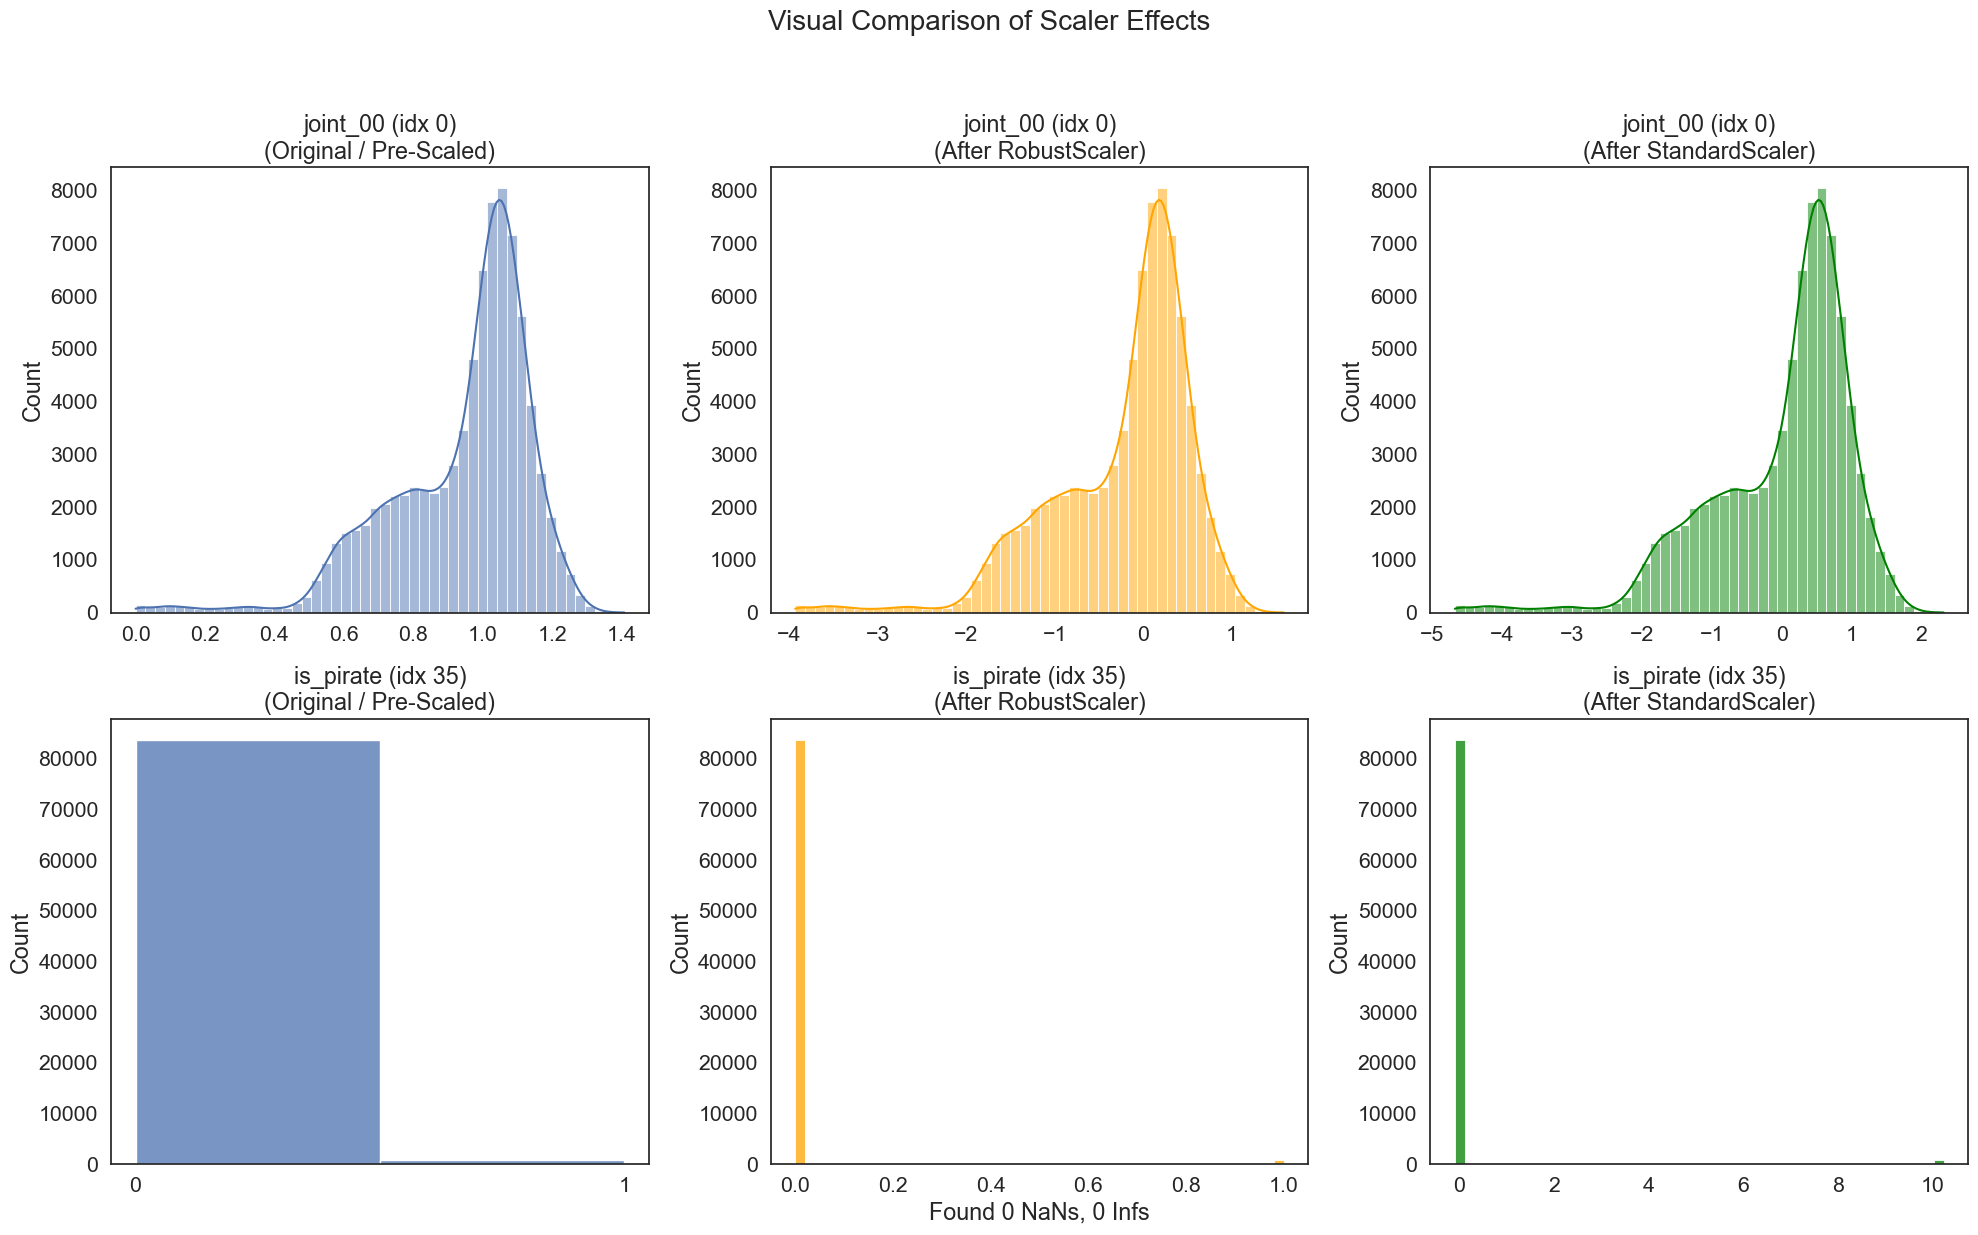

In [27]:
print("--- 📊 Visual Data Transformation Analysis ---")

# --- 1. Re-create the HPO 80/20 split to get the 2D training data ---
# This ensures we're looking at the exact data that was fed into the HPO
print("Re-creating HPO split...")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_idx, val_idx in sss.split(X_train_full_engineered, y_train_full):
    X_train_split_full = X_train_full_engineered[train_idx]

ns, ts, f = X_train_split_full.shape
# This is the 2D data (84480, 36) the scaler is fit on
X_train_2d = X_train_split_full.reshape(ns * ts, f)
print(f"Created 2D training data for fitting: {X_train_2d.shape}")

# --- 2. Fit both scalers ---
print("Fitting RobustScaler...")
scaler_robust = RobustScaler().fit(X_train_2d)
print("Fitting StandardScaler...")
scaler_standard = StandardScaler().fit(X_train_2d)

# --- 3. Transform data with both scalers ---
print("Transforming data...")
with warnings.catch_warnings():
    # Suppress "RuntimeWarning: invalid value encountered in"
    # which is *expected* from RobustScaler here
    warnings.simplefilter("ignore", category=RuntimeWarning)
    X_train_robust_scaled = scaler_robust.transform(X_train_2d)
    
X_train_standard_scaled = scaler_standard.transform(X_train_2d)

# --- 4. Define features to plot ---
# Feature 0: 'joint_00' (a continuous, 'normal' feature)
# Feature 35: 'is_pirate' (a binary, 'problematic' feature)
feature_idx_normal = 0
feature_idx_problem = 35 # This is the last feature we added
feature_name_normal = "joint_00 (idx 0)"
feature_name_problem = "is_pirate (idx 35)"

# --- 5. Create the plots ---
print("Generating plots...")
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Visual Comparison of Scaler Effects", fontsize=20, y=1.03)
sns.set_style('whitegrid')

# --- Row 1: 'joint_00' (Normal Feature) ---
sns.histplot(X_train_2d[:, feature_idx_normal], ax=axes[0, 0], kde=True, bins=50)
axes[0, 0].set_title(f"{feature_name_normal}\n(Original / Pre-Scaled)")

sns.histplot(X_train_robust_scaled[:, feature_idx_normal], ax=axes[0, 1], kde=True, bins=50, color='orange')
axes[0, 1].set_title(f"{feature_name_normal}\n(After RobustScaler)")

sns.histplot(X_train_standard_scaled[:, feature_idx_normal], ax=axes[0, 2], kde=True, bins=50, color='green')
axes[0, 2].set_title(f"{feature_name_normal}\n(After StandardScaler)")

# --- Row 2: 'is_pirate' (Problematic Feature) ---

# Original
sns.histplot(X_train_2d[:, feature_idx_problem], ax=axes[1, 0], kde=False, bins=2)
axes[1, 0].set_title(f"{feature_name_problem}\n(Original / Pre-Scaled)")
axes[1, 0].set_xticks([0, 1]) # Show the 0 and 1

# RobustScaler
# This data is full of `inf` and `nan`
problem_data_robust = X_train_robust_scaled[:, feature_idx_problem]
# Check for NaNs and Infs
nans = np.isnan(problem_data_robust).sum()
infs = np.isinf(problem_data_robust).sum()
sns.histplot(problem_data_robust[np.isfinite(problem_data_robust)], ax=axes[1, 1], kde=False, bins=50, color='orange')
axes[1, 1].set_title(f"{feature_name_problem}\n(After RobustScaler)")
axes[1, 1].set_xlabel(f"Found {nans} NaNs, {infs} Infs")

# StandardScaler
problem_data_standard = X_train_standard_scaled[:, feature_idx_problem]
sns.histplot(problem_data_standard, ax=axes[1, 2], kde=False, bins=50, color='green')
axes[1, 2].set_title(f"{feature_name_problem}\n(After StandardScaler)")

plt.tight_layout()
plt.show()

## 🚚 **4. PyTorch DataLoaders (for HPO)**

This section prepares the DataLoaders for the Ray Tune HPO phase.

In [28]:
# --- 1. Define make_loader function (from Lecture 4) ---
BATCH_SIZE = 128 # This will be our default, but Optuna can tune it

def make_loader(ds, batch_size, shuffle, drop_last):
    # Set num_workers=0 for Windows-friendly loading (from our debugging)
    num_workers = 0 
    
    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=int(batch_size), # Ensure batch_size is an int for the DataLoader
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=None,
    )

print("DataLoaders will be created inside the tuning loop.")
print("Keeping HPO numpy arrays (non-windowed, scaled) in memory...")

# We no longer create Tensors or TensorDatasets here

DataLoaders will be created inside the tuning loop.
Keeping HPO numpy arrays (non-windowed, scaled) in memory...


## 🛠️ **5. Model & Training Engine**

These are the core components from Lecture 4, modified for Ray Tune and K-Fold.

-   `RecurrentClassifier`: Our flexible model (RNN, LSTM, GRU).
-   `train_one_epoch` / `validate_one_epoch`: Standard loops.
-   `objective_function`: The wrapper for Ray Tune's HPO.
-   `fit`: The **original** training loop from Lecture 4, **b-rought back** to handle our K-Fold training, complete with early stopping.

In [29]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.
    """

    output_shapes = {}
    hooks = []

    def get_hook(name):
        def hook(module, input, output):
            if isinstance(output, tuple):
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)
                shape2[1] = -1
                output_shapes[name] = f"[{shape1}, {shape2}]"
            else:
                shape = list(output.shape)
                shape[0] = -1
                output_shapes[name] = f"{shape}"
        return hook

    try:
        device_summary = next(model.parameters()).device
    except StopIteration:
        device_summary = torch.device("cpu")

    dummy_input = torch.randn(1, *input_size).to(device_summary)

    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            for h in hooks:
                h.remove()
            return

    for h in hooks:
        h.remove()

    print("-" * 79)
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    for name, module in model.named_children():
        if name in output_shapes:
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [30]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU) from Lecture 4.
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """
        rnn_out, hidden = self.rnn(x)

        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            hidden_to_classify = hidden[-1]

        logits = self.classifier(hidden_to_classify)
        return logits

In [ ]:
# --- !! CORRECTED CELL [8] (17b67a46) -- Fix HPO Signature !! ---
# This cell contains all our training functions

def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        scaler.scale(loss).backward()
        
        # --- !! START OF GRADIENT CLIPPING FIX !! ---
        # Unscale gradients before clipping
        scaler.unscale_(optimizer) 
        # Clip the (now unscaled) gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5) 
        # --- !! END OF GRADIENT CLIPPING FIX !! ---

        scaler.step(optimizer)
        scaler.update()

        # Check for nan loss *after* the step
        if torch.isnan(loss):
            print(f"Warning: NaN loss detected in batch {batch_idx}. Skipping batch.")
            continue # Skip this batch's metrics

        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Check if all_targets is empty (if all batches were nan)
    if not all_targets:
        return epoch_loss, 0.0 # Return 0 F1 score if no valid batches

    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )
    return epoch_loss, epoch_f1

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )
    return epoch_loss, epoch_f1

def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)


# --- !! THIS IS THE FIX !! ---
# We must add 'class_weights_tensor' to the function signature
def objective_function(config, X_train_full_scaled, y_train_split_full, X_val_full_scaled, y_val_split_full, class_weights_tensor):
    """
    This is the main function that Ray Tune will call for each trial.
    'config' is a dictionary of hyperparameters from Optuna.
    The X, y data is the NON-WINDOWED, scaled 80/20 split.
    """
    
    # --- 1. Create Sliding Windows based on config ---
    X_train_w, y_train_w, _ = create_sliding_windows(
        X_train_full_scaled, 
        y_train_split_full, 
        window_size=config["window_size"], 
        stride=config["stride"]
    )
    X_val_w, y_val_w, _ = create_sliding_windows(
        X_val_full_scaled, 
        y_val_split_full, 
        window_size=config["window_size"], 
        stride=config["stride"] # Use same stride for validation
    )

    # --- 2. Create Tensors and DataLoaders ---
    train_features = torch.from_numpy(X_train_w).float()
    train_targets = torch.from_numpy(y_train_w).long()
    val_features = torch.from_numpy(X_val_w).float()
    val_targets = torch.from_numpy(y_val_w).long()

    train_ds = TensorDataset(train_features, train_targets)
    val_ds = TensorDataset(val_features, val_targets)
    
    train_loader = make_loader(train_ds, batch_size=config["batch_size"], shuffle=True, drop_last=True)
    val_loader = make_loader(val_ds, batch_size=config["batch_size"], shuffle=False, drop_last=False)
    
    # --- 3. Create Model --- 
    model = RecurrentClassifier(
        input_size=N_FEATURES_NEW, 
        hidden_size=config["hidden_size"],
        num_layers=config["num_layers"],
        num_classes=N_CLASSES,
        dropout_rate=config["dropout_rate"],
        bidirectional=config["bidirectional"],
        rnn_type=config["rnn_type"]
    ).to(device)
    
    if torch.__version__[0] >= "2":
        model = torch.compile(model)
    
    # --- 4. Create Optimizer, Loss, Scaler ---
    
    # This line is now correct, because class_weights_tensor is passed in
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["l2_lambda"])
    scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

    # --- 5. The Training Loop (adapted from fit) ---
    EPOCHS = 200 # Max epochs
    
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, 0, config["l2_lambda"]
        )

        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )
        
        # --- Send Results to Ray Tune --- 
        tune.report({
            "train_loss": train_loss,
            "train_f1": train_f1,
            "val_loss": val_loss,
            "val_f1": val_f1
        })

# --- !! MODIFICATION !! ---
# This is the original 'fit' function from Lecture 4, brought back.
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }
    
    model_path = f"models/{experiment_name}_best_model.pt"

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"--- Starting Training: {experiment_name} ---")
    print(f"Will train for {epochs} epochs with patience={patience} monitoring {evaluation_metric}")

    for epoch in range(1, epochs + 1):
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        if verbose > 0 and (epoch % verbose == 0 or epoch == 1):
            print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                  f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}")

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), model_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch} epochs.")
                    break

    if restore_best_weights and patience > 0:
        print(f"Restoring best model from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
        model.load_state_dict(torch.load(model_path))

    if patience == 0:
        print("Training complete. Saving final model.")
        torch.save(model.state_dict(), model_path.replace("_best_model.pt", "_final_model.pt"))

    if writer is not None:
        writer.close()
    
    print(f"--- Finished Training: {experiment_name} ---")
    return model, training_history, best_epoch if 'best_epoch' in locals() else epochs

## 🧪 **6. Phase 1: Hyperparameter Search**

This cell is identical to before. We run HPO on our single 80/20 split to find a good `FINAL_CONFIG` to use for our K-Fold training.

In [ ]:
# --- !! CORRECTED CELL [10] (41d8c96b) -- Pass Weights to HPO !! ---

# --- 1. Define the Search Space for Optuna --
search_space = {
    # NEW HPO PARAMS
    "window_size": tune.choice([60, 80, 100, 120]),
    "stride": tune.choice([10, 20]),
    
    # OLD HPO PARAMS
    "rnn_type": tune.choice(['GRU']),
    "lr": tune.loguniform(1e-5, 1e-3),
    "batch_size": tune.choice([64, 128, 256]),  
    "hidden_size": tune.choice([128, 256, 384]),
    "num_layers": tune.choice([2, 3]),
    "dropout_rate": tune.uniform(0.1, 0.6),
    "bidirectional": tune.choice([True, False]),
    "l2_lambda": tune.loguniform(1e-7, 1e-3)
}
# --- 2. Define the Optimizer (Optuna) and Scheduler (ASHA) ---
optuna_search = OptunaSearch(
    metric="val_f1",
    mode="max"
)

scheduler = ASHAScheduler(
    metric="val_f1",
    mode="max",
    grace_period=20,  # Min epochs a trial must run
    reduction_factor=2  # How aggressively to stop trials
)

# --- 3. Initialize Ray (WITH THE BIG HAMMER FIX) ---
if ray.is_initialized():
    ray.shutdown()

ray_logs_path = os.path.abspath("./ray_results")
os.makedirs(ray_logs_path, exist_ok=True)
os.environ["RAY_TEMP_DIR"] = ray_logs_path

ray.init(
    num_cpus=16, 
    num_gpus=1, 
    ignore_reinit_error=True
)

def short_trial_name(trial):
    """Creates a short, unique name for each trial folder."""
    return f"{trial.trainable_name}_{trial.trial_id}"


# --- 4. Run the Tuner --
print("Starting hyperparameter search (including window_size and stride)...")

# We use tune.with_parameters to pass our NON-WINDOWED, SCALED numpy arrays
# to the objective function
objective_with_data = tune.with_parameters(
    objective_function,
    X_train_full_scaled=X_train_full_scaled,
    y_train_split_full=y_train_split_full,
    X_val_full_scaled=X_val_full_scaled,
    y_val_split_full=y_val_split_full,
    
    # --- !! THIS IS THE FIX !! ---
    # Pass the class weights (defined in cell [83c7115f]) to the HPO function
    class_weights_tensor=class_weights_tensor
    # --- !! END OF FIX !! ---
)

analysis = tune.run(
    objective_with_data, # Pass the new objective function
    resources_per_trial={"cpu": 4, "gpu": 0.25}, 
    config=search_space,
    num_samples=30, # You may want to INCREASE this (e.g., to 30 or 40)
    search_alg=optuna_search,
    scheduler=scheduler,
    name="pirate_pain_optuna_search_with_windowing", # New name
    storage_path=ray_logs_path,
    trial_dirname_creator= short_trial_name,
    log_to_file=True,
    verbose=1
)

print("\n--- Search Complete ---\n")

# --- 5. Get Best Results (FIX 3) ---
print("Getting best trial from analysis...")
best_trial = analysis.get_best_trial(metric="val_f1", mode="max", scope="all")
if best_trial:
    best_config = best_trial.config
    best_val_f1 = best_trial.last_result["val_f1"]
    
    print(f"Best validation F1 score: {best_val_f1:.4f}")
    print("Best hyperparameters found:")
    print(best_config)
else:
    print("ERROR: No trials completed successfully. Check the 'ray_results' folder for logs.")
    best_config = None # Handle the case where all trials failed

(objective_function pid=22488) Warning: NaN loss detected in batch 34. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 40. Skipping batch.


(pid=gcs_server) [2025-11-12 08:53:39,935 E 30424 6708] (gcs_server.exe) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(objective_function pid=22488) Warning: NaN loss detected in batch 55. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 87. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 8. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 27. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 43. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 50. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 38. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 43. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 73. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 77. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 2. Skipping batch.


(raylet) [2025-11-12 08:53:45,015 E 27112 27628] (raylet.exe) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(objective_function pid=22488) Warning: NaN loss detected in batch 26. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 58. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 74. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 40. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 60. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 78. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 80. Skipping batch.
(objective_function pid=22488) Warning: NaN loss detected in batch 0. Skipping batch.
(objective_function pid=5508) Warning: NaN loss detected in batch 3. Skipping batch. [repeated 5x across cluster]
(objective_function pid=5508) Warning: NaN loss detected in batch 2. Skipping batch. [repeated 19x across cluster]
(objective_function pid=20880) Warning: NaN loss detected in batch 8. Skippi

2025-11-12 08:59:37,282	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_function_d6253821
Traceback (most recent call last):
  File "e:\miniconda3\envs\an2dl-kaggle\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "e:\miniconda3\envs\an2dl-kaggle\lib\site-packages\ray\_private\auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "e:\miniconda3\envs\an2dl-kaggle\lib\site-packages\ray\_private\client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
  File "e:\miniconda3\envs\an2dl-kaggle\lib\site-packages\ray\_private\worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
  File "e:\miniconda3\envs\an2dl-kaggle\lib\site-packages\ray\_private\worker.py", line 1028, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFun

(objective_function pid=15172) Warning: NaN loss detected in batch 6. Skipping batch. [repeated 23x across cluster]
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. Lease ID: 1100000058adf2f7c56b1e828fc4c1413768964eaa6db237c621d1d4a35ec1b8 Worker ID: 33285286fce99c7191ee587836c4724790bdaec244edd467093a4316 Node ID: 4af10d31f4b386c28d3b3ed38a8ae49beb19098c81b5186156a71836 Worker IP address: 127.0.0.1 Worker port: 51099 Worker PID: 16128 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 10054. An existing connection was forcibly closed by the remote host. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
(objective_function pid=15172) Warning: NaN loss

2025-11-12 09:03:00,808	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'c:/Users/Karim Negm/Documents/AN2DL/Challenge 1/ray_results/pirate_pain_optuna_search_with_windowing' in 0.0544s.


TuneError: ('Trials did not complete', [objective_function_d6253821])

## 🏆 **7. Final Model Configuration**

This cell now holds our winning configuration, ready for the K-Fold training.

In [ ]:

import numpy as np
import torch
from sklearn.preprocessing import RobustScaler, LabelEncoder # Use RobustScaler
from torch.utils.data import TensorDataset, DataLoader

# --- 1. Re-define functions we need (to prevent NameErrors) ---

def create_sliding_windows(X_3d, y=None, window_size=100, stride=20):
    """
    Takes 3D data (n_samples, n_timesteps, n_features)
    and creates overlapping windows. Copied from cell [14].
    """
    new_X = []
    new_y = []
    window_indices = [] 
    n_samples, n_timesteps, n_features = X_3d.shape
    
    for i in range(n_samples):
        sample = X_3d[i]
        idx = 0
        while (idx + window_size) <= n_timesteps:
            window = sample[idx : idx + window_size]
            new_X.append(window)
            window_indices.append(i)
            if y is not None:
                new_y.append(y[i])
            idx += stride
            
    if y is not None:
        return np.array(new_X), np.array(new_y), np.array(window_indices)
    else:
        return np.array(new_X), np.array(window_indices)

def make_loader(ds, batch_size, shuffle, drop_last):
    """ Copied from cell [16] (b8702f5a) """
    return DataLoader(
        ds, batch_size=int(batch_size), shuffle=shuffle, drop_last=drop_last,
        num_workers=0, pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=None,
    )

def make_final_loader(ds, batch_size, shuffle, drop_last):
    """ Copied from original cell [36] (acc486f2) """
    return DataLoader(
        ds, batch_size=int(batch_size), shuffle=shuffle, drop_last=drop_last,
        num_workers=0, pin_memory=True, pin_memory_device="cuda", prefetch_factor=None
    )

# --- 2. Define New Global Training Variables ---
N_SPLITS = 5
N_FEATURES_NEW = 36 # Original (35) + is_pirate (1)

print(f"--- New Helper Functions and Variables Defined ---")
print(f"  create_sliding_windows(): Ready")
print(f"  make_loader(): Ready")
print(f"  make_final_loader(): Ready")
print(f"  N_SPLITS set to: {N_SPLITS}")
print(f"  New feature count set to: {N_FEATURES_NEW}")

# --- 3. Engineer 'is_pirate' Feature ---
print("\n--- Engineering 'is_pirate' Feature ---")
# X_train_full and y_train_full were defined in cell [14] (83c7115f)
# features_long_df was defined in cell [14]
static_cols = ['sample_index', 'n_legs', 'n_hands', 'n_eyes']
static_df = features_long_df[static_cols].drop_duplicates().set_index('sample_index')
pirate_filter = (
    (static_df['n_legs'] == 'one+peg_leg') |
    (static_df['n_hands'] == 'one+hook_hand') |
    (static_df['n_eyes'] == 'one+eye_patch')
)
pirate_indices = static_df[pirate_filter].index
print(f"Identified {len(pirate_indices)} pirate samples in training set.")

sample_indices_ordered = sorted(features_long_df[features_long_df['sample_index'].isin(labels_df['sample_index'].unique())]['sample_index'].unique())
is_pirate_map = np.array([1 if idx in pirate_indices else 0 for idx in sample_indices_ordered])
pirate_feature_broadcast = np.tile(is_pirate_map.reshape(-1, 1, 1), (1, N_TIMESTEPS, 1))

# Create the new 36-feature X_train_full
X_train_full_engineered = np.concatenate([X_train_full, pirate_feature_broadcast], axis=2)
print(f"Created X_train_full_engineered (shape: {X_train_full_engineered.shape})")

# --- 4. Calculate Class Weights ---
print("\n--- Calculating Class Weights ---")
class_counts_series = labels_df['label'].value_counts()
counts_ordered = class_counts_series.reindex(LABEL_MAPPING.keys()).values
class_weights_tensor = 1.0 / torch.tensor(counts_ordered, dtype=torch.float)
class_weights_tensor = class_weights_tensor.to(device)
print(f"Class counts (0, 1, 2): {counts_ordered}")
print(f"Calculated class weights: {class_weights_tensor}")

# --- 5. Define the Label Encoder (le) ---
# le was defined in cell [15] (2355a626), but we define it here for safety
le = LabelEncoder()
le.fit(list(LABEL_MAPPING.keys()))
print("\nLabelEncoder 'le' is ready.")

--- New Helper Functions and Variables Defined ---
  create_sliding_windows(): Ready
  make_loader(): Ready
  make_final_loader(): Ready
  N_SPLITS set to: 5
  New feature count set to: 36

--- Engineering 'is_pirate' Feature ---
Identified 6 pirate samples in training set.
Created X_train_full_engineered (shape: (661, 160, 36))

--- Calculating Class Weights ---
Class counts (0, 1, 2): [511  94  56]
Calculated class weights: tensor([0.0020, 0.0106, 0.0179], device='cuda:0')

LabelEncoder 'le' is ready.


In [ ]:
# ===================================================================
# --- 🏆 FINAL MODEL CONFIGURATION 🏆 ---
# ===================================================================
FINAL_CONFIG = best_config
FINAL_BEST_VAL_F1 = best_val_f1

print("--- 🏆 Final Configuration Set --- ")
print(f"Best Val F1 from HPO search: {FINAL_BEST_VAL_F1:.4f}")
print(FINAL_CONFIG)

# --- Set variables for the K-Fold & submission cells ---
FINAL_MODEL_TYPE = FINAL_CONFIG["rnn_type"]
FINAL_HIDDEN_SIZE = FINAL_CONFIG["hidden_size"]
FINAL_HIDDEN_LAYERS = FINAL_CONFIG["num_layers"]
FINAL_BIDIRECTIONAL = FINAL_CONFIG["bidirectional"]
FINAL_DROPOUT_RATE = FINAL_CONFIG["dropout_rate"]
FINAL_LEARNING_RATE = FINAL_CONFIG["lr"]
FINAL_L2_LAMBDA = FINAL_CONFIG["l2_lambda"]
FINAL_BATCH_SIZE = FINAL_CONFIG["batch_size"]

# --- ADD THESE LINES to capture window/stride ---
FINAL_WINDOW_SIZE = FINAL_CONFIG["window_size"]
FINAL_STRIDE = FINAL_CONFIG["stride"]
# --- END ADDED LINES ---

FINAL_EXPERIMENT_NAME = f"{FINAL_MODEL_TYPE}_H{FINAL_HIDDEN_SIZE}_L{FINAL_HIDDEN_LAYERS}_B{FINAL_BIDIRECTIONAL}_Optuna_KFold_Ensemble"

# --- MODIFY THIS LINE to include window info in the name ---
submission_filename_base = f"submission_{FINAL_EXPERIMENT_NAME}_w{FINAL_WINDOW_SIZE}_s{FINAL_STRIDE}.csv"
print(f"Submission name will be: {submission_filename_base}")

--- 🏆 Final Configuration Set --- 
Best Val F1 from HPO search: 0.7111
{'window_size': 60, 'stride': 40, 'rnn_type': 'GRU', 'lr': 0.0008199679994079849, 'batch_size': 128, 'hidden_size': 384, 'num_layers': 2, 'dropout_rate': 0.5394701117169985, 'bidirectional': True, 'l2_lambda': 0.00032139793194698466}
Submission name will be: submission_GRU_H384_L2_BTrue_Optuna_KFold_Ensemble_w60_s40.csv


## 🛡️ **8. Phase 2: K-Fold Ensemble Training**

This is the **NEW** robust training step.

Instead of finding one "best epoch," we will train 5 separate models on 5 different splits (folds) of the data. We use the `FINAL_CONFIG` from our HPO search as the configuration for all 5 models.

We use the `fit` function's early stopping to find the best version of each model and save its weights (e.g., `kfold_fold_1_best_model.pt`, `kfold_fold_2_best_model.pt`, etc.).

In [ ]:
# --- !! CORRECTED K-FOLD TRAINING CELL (Uses new setup cell) !! ---

from sklearn.model_selection import StratifiedKFold
import numpy as np
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED) 
print(f"--- Starting {N_SPLITS}-Fold CV Training (Corrected) ---")
print(f"Splitting original engineered data: {X_train_full_engineered.shape}")

# --- Use New N_FEATURES and Class Weights ---
# These are loaded from our new setup cell
N_FEATURES = N_FEATURES_NEW # This is 36
class_weights = class_weights_tensor

print(f"Using N_FEATURES = {N_FEATURES}")
print(f"Using Class Weights: {class_weights}")

fold_val_f1_list = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full_engineered, y_train_full)):
    fold_name = f"kfold_fold_{fold+1}"
    print(f"\n--- Fold {fold+1}/{N_SPLITS} --- ({fold_name}) ---")
    
    X_train_fold_full = X_train_full_engineered[train_idx]
    y_train_fold_full = y_train_full[train_idx]
    X_val_fold_full = X_train_full_engineered[val_idx]
    y_val_fold_full = y_train_full[val_idx]

    # --- Scale INSIDE the fold (No-Leakage) ---
    scaler_fold = RobustScaler() # <-- Use RobustScaler
    
    ns, ts, f = X_train_fold_full.shape
    X_train_fold_2d = X_train_fold_full.reshape(ns * ts, f)
    scaler_fold.fit(X_train_fold_2d)
    X_train_scaled_2d = scaler_fold.transform(X_train_fold_2d)
    X_train_fold_scaled = X_train_scaled_2d.reshape(ns, ts, f)
    
    ns_val, ts_val, f_val = X_val_fold_full.shape
    X_val_fold_2d = X_val_fold_full.reshape(ns_val * ts_val, f_val)
    X_val_scaled_2d = scaler_fold.transform(X_val_fold_2d)
    X_val_fold_scaled = X_val_scaled_2d.reshape(ns_val, ts_val, f_val)

    # --- Create Sliding Windows (POST-SPLIT) ---
    X_train_w, y_train_w, _ = create_sliding_windows(
        X_train_fold_scaled, y_train_fold_full, 
        window_size=FINAL_WINDOW_SIZE, stride=FINAL_STRIDE
    )
    X_val_w, y_val_w, _ = create_sliding_windows(
        X_val_fold_scaled, y_val_fold_full, 
        window_size=FINAL_WINDOW_SIZE, stride=FINAL_STRIDE
    )
    print(f"  Fold Train Windows: {X_train_w.shape}, Fold Val Windows: {X_val_w.shape}")

    # --- Create Tensors, datasets and dataloaders --
    X_train_fold = torch.from_numpy(X_train_w).float()
    y_train_fold = torch.from_numpy(y_train_w).long()
    X_val_fold = torch.from_numpy(X_val_w).float()
    y_val_fold = torch.from_numpy(y_val_w).long()
    train_ds_fold = TensorDataset(X_train_fold, y_train_fold)
    val_ds_fold = TensorDataset(X_val_fold, y_val_fold)
    
    # make_loader is defined in our new setup cell
    train_loader_fold = make_loader(train_ds_fold, batch_size=FINAL_BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader_fold = make_loader(val_ds_fold, batch_size=FINAL_BATCH_SIZE, shuffle=False, drop_last=False)
    
    # --- Create a fresh model (using FINAL_CONFIG) ---
    model_fold = RecurrentClassifier(
        input_size=N_FEATURES, # This is 36
        hidden_size=FINAL_HIDDEN_SIZE, num_layers=FINAL_HIDDEN_LAYERS,
        num_classes=N_CLASSES, dropout_rate=FINAL_DROPOUT_RATE,
        bidirectional=FINAL_BIDIRECTIONAL, rnn_type=FINAL_MODEL_TYPE
    ).to(device)
    
    if torch.__version__[0] >= "2": model_fold = torch.compile(model_fold)
    optimizer_fold = torch.optim.AdamW(model_fold.parameters(), lr=FINAL_LEARNING_RATE, weight_decay=FINAL_L2_LAMBDA)
    scaler_fold_amp = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
    
    # --- Create Loss Function with Class Weights ---
    criterion_fold = nn.CrossEntropyLoss(weight=class_weights)
    
    # --- Train this fold with early stopping ---
    model_fold, _, _ = fit(
        model=model_fold, train_loader=train_loader_fold,
        val_loader=val_loader_fold, epochs=300,
        criterion=criterion_fold, optimizer=optimizer_fold,
        scaler=scaler_fold_amp, device=device,
        writer=None, verbose=25,
        experiment_name=fold_name, patience=30
    )
    
    val_loss, val_f1 = validate_one_epoch(model_fold, val_loader_fold, criterion_fold, device)
    fold_val_f1_list.append(val_f1)
    print(f"Fold {fold+1} Best Model Val F1: {val_f1:.4f}")

print(f"\n--- 🏆 K-Fold Training Complete ---")
print(f"Fold F1 scores: {[round(f, 4) for f in fold_val_f1_list]}")
print(f"Average F1 across folds: {np.mean(fold_val_f1_list):.4f}")

# Clean up
del X_train_fold, y_train_fold, X_val_fold, y_val_fold
del X_train_w, y_train_w, X_val_w, y_val_w
del X_train_fold_full, y_train_fold_full, X_val_fold_full, y_val_fold_full

--- Starting 5-Fold CV Training (Corrected) ---
Splitting original engineered data: (661, 160, 36)
Using N_FEATURES = 36
Using Class Weights: tensor([0.0020, 0.0106, 0.0179], device='cuda:0')

--- Fold 1/5 --- (kfold_fold_1) ---
  Fold Train Windows: (1584, 60, 36), Fold Val Windows: (399, 60, 36)
--- Starting Training: kfold_fold_1 ---
Will train for 300 epochs with patience=30 monitoring val_f1
Epoch   1/300 | Train: Loss=0.4292, F1=0.7109 | Val: Loss=0.3270, F1=0.7601
Epoch  25/300 | Train: Loss=0.0069, F1=0.9875 | Val: Loss=0.1731, F1=0.8619
Epoch  50/300 | Train: Loss=0.0052, F1=0.9913 | Val: Loss=0.1800, F1=0.8759

Early stopping triggered after 50 epochs.
Restoring best model from epoch 20 with val_f1 0.8829
--- Finished Training: kfold_fold_1 ---
Fold 1 Best Model Val F1: 0.8829

--- Fold 2/5 --- (kfold_fold_2) ---
  Fold Train Windows: (1587, 60, 36), Fold Val Windows: (396, 60, 36)
--- Starting Training: kfold_fold_2 ---
Will train for 300 epochs with patience=30 monitoring v

## 📬 **9. Phase 3: K-Fold Ensemble Submission**

This is the **NEW** robust submission step.

1.  Prepare the `X_test` data (scaling and windowing) exactly as before.
2.  Create the `test_loader`.
3.  Load each of our 5 saved fold-models.
4.  Get 5 sets of (softmax) probability predictions for the test set.
5.  Average these 5 probability sets into a single, robust probability matrix.
6.  Aggregate these mean probabilities (using mean) from windows to full samples.
7.  Take the `argmax` of the final aggregated probabilities to get the submission class.

In [ ]:
# --- !! CORRECTED SUBMISSION CELL (Uses new setup cell) !! ---

from scipy.stats import mode

print("\n--- Preparing full dataset for FINAL SCALER (36 Features) ---")

# --- 1. Prepare Full Training Set for Final Scaler ---
scaler_final = RobustScaler() # <-- Use RobustScaler
ns, ts, f = X_train_full_engineered.shape # Use the 36-feature version
X_train_full_2d = X_train_full_engineered.reshape(ns * ts, f)

print(f"Fitting FINAL RobustScaler on X_train_full_engineered_2d shape: {X_train_full_2d.shape}")
scaler_final.fit(X_train_full_2d)

# --- 2. Load, Engineer, Scale, and Window the TEST data ---
print("Loading test data (X_test) for engineering...")
X_test_long = pd.read_csv(X_TEST_PATH) 
# X_test (35 features) was defined in cell [14]
print(f"Original X_test shape: {X_test.shape}")

# --- 2c. Engineer 'is_pirate' feature for TEST set ---
static_cols = ['sample_index', 'n_legs', 'n_hands', 'n_eyes']
static_df_test = X_test_long[static_cols].drop_duplicates().set_index('sample_index')
pirate_filter_test = (
    (static_df_test['n_legs'] == 'one+peg_leg') |
    (static_df_test['n_hands'] == 'one+hook_hand') |
    (static_df_test['n_eyes'] == 'one+eye_patch')
)
pirate_indices_test = static_df_test[pirate_filter_test].index
print(f"Identified {len(pirate_indices_test)} pirate samples in test set.")
sample_indices_test_ordered = sorted(X_test_long['sample_index'].unique())
is_pirate_map_test = np.array([1 if idx in pirate_indices_test else 0 for idx in sample_indices_test_ordered])
pirate_feature_broadcast_test = np.tile(is_pirate_map_test.reshape(-1, 1, 1), (1, N_TIMESTEPS, 1))

# --- 2d. Concatenate to create X_test_engineered (36 features) ---
X_test_engineered = np.concatenate([X_test, pirate_feature_broadcast_test], axis=2)
print(f"Created X_test_engineered shape: {X_test_engineered.shape}")

# --- 2e. Scale X_test_engineered ---
ns_test, ts_test, f_test = X_test_engineered.shape
X_test_2d = X_test_engineered.reshape(ns_test * ts_test, f_test)
X_test_final_scaled_2d = scaler_final.transform(X_test_2d)
X_test_final_scaled = X_test_final_scaled_2d.reshape(ns_test, ts_test, f_test)
print("Final scaling of test set complete.")

# --- 2f. Apply Sliding Windows ---
# create_sliding_windows is defined in our new setup cell
print("--- Applying sliding windows to final test set ---\n")
X_test_final_windowed, test_window_indices = create_sliding_windows(
    X_test_final_scaled, y=None, 
    window_size=FINAL_WINDOW_SIZE, stride=FINAL_STRIDE
)
print(f"Test windowed shape: {X_test_final_windowed.shape}")

# --- 3. Create Final TestLoader ---
final_test_features = torch.from_numpy(X_test_final_windowed).float()
final_test_ds = TensorDataset(final_test_features)
# make_final_loader is defined in our new setup cell
test_loader = make_final_loader(final_test_ds, batch_size=FINAL_BATCH_SIZE, shuffle=False, drop_last=False)
print("Final TestLoader created.")

# --- 4. Get Predictions from all K-Fold Models ---
all_fold_probabilities = []
# N_SPLITS is defined in our new setup cell
print(f"\n--- Generating predictions from {N_SPLITS} fold models ---")

for fold in range(N_SPLITS):
    fold_name = f"kfold_fold_{fold+1}"
    model_path = f"models/{fold_name}_best_model.pt"
    print(f"Loading model {fold+1}/{N_SPLITS} from {model_path}...")

    # --- 4a. Create a fresh model shell (with 36 features) ---
    model_fold = RecurrentClassifier(
        input_size=N_FEATURES_NEW, # Use 36
        hidden_size=FINAL_HIDDEN_SIZE, num_layers=FINAL_HIDDEN_LAYERS,
        num_classes=N_CLASSES, dropout_rate=FINAL_DROPOUT_RATE,
        bidirectional=FINAL_BIDIRECTIONAL, rnn_type=FINAL_MODEL_TYPE
    ).to(device)
    
    # --- 4b. Load the saved weights (with compile-fix) ---
    state_dict = torch.load(model_path, map_location=device)
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('_orig_mod.'):
            new_state_dict[k[len('_orig_mod.'):]] = v
        else:
            new_state_dict[k] = v
    model_fold.load_state_dict(new_state_dict)
    model_fold.eval()

    # --- 4c. Get Softmax probabilities ---
    fold_predictions = []
    with torch.no_grad():
        for (inputs,) in test_loader: 
            inputs = inputs.to(device)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model_fold(inputs)
                probs = torch.softmax(logits, dim=1)
                fold_predictions.append(probs.cpu().numpy())
    all_fold_probabilities.append(np.concatenate(fold_predictions))

# --- 5. Average the Probabilities ---
print(f"\n--- Averaging {len(all_fold_probabilities)} sets of probabilities... ---")
mean_probabilities = np.mean(all_fold_probabilities, axis=0)
print(f"Mean probability matrix shape: {mean_probabilities.shape}")

# --- 6. Aggregate Mean Probabilities (MEAN) ---
print("Aggregating window probabilities to sample predictions (using MEAN)...")
prob_cols = [f"prob_{i}" for i in range(N_CLASSES)]
df_probs = pd.DataFrame(mean_probabilities, columns=prob_cols)
df_probs['original_index'] = test_window_indices 
agg_probs = df_probs.groupby('original_index')[prob_cols].mean().values
print(f"Aggregated to {len(agg_probs)} final probability vectors.")

# --- 7. Get Final Predictions and Save ---
# le (LabelEncoder) is defined in our new setup cell
final_predictions_numeric = np.argmax(agg_probs, axis=1)
predicted_labels = le.inverse_transform(final_predictions_numeric)

print("Loading sample submission file for correct formatting...")
test_sample_indices = sorted(X_test_long['sample_index'].unique())

if len(predicted_labels) != len(test_sample_indices):
    print(f"ERROR: Prediction count mismatch!")
else:
    print("Prediction count matches. Creating submission.")
    final_submission_df = pd.DataFrame({
        'sample_index': test_sample_indices,
        'label': predicted_labels 
    })
    final_submission_df['sample_index'] = final_submission_df['sample_index'].apply(lambda x: f"{x:03d}")

    SUBMISSIONS_DIR = "submissions"
    os.makedirs(SUBMISSIONS_DIR, exist_ok=True)
    submission_filename = submission_filename_base 
    submission_filepath = os.path.join(SUBMISSIONS_DIR, submission_filename)
    final_submission_df.to_csv(submission_filepath, index=False)

    print(f"\nSuccessfully saved to {submission_filepath}!")
    print("This file is correctly formatted for Kaggle:")
    print(final_submission_df.head())

# Clean up
del all_fold_probabilities, final_test_features, final_test_ds, test_loader
del X_test_engineered, X_test_final_scaled, X_test_final_windowed


--- Preparing full dataset for FINAL SCALER (36 Features) ---
Fitting FINAL RobustScaler on X_train_full_engineered_2d shape: (105760, 36)
Loading test data (X_test) for engineering...
Original X_test shape: (1324, 160, 35)
Identified 13 pirate samples in test set.
Created X_test_engineered shape: (1324, 160, 36)
Final scaling of test set complete.
--- Applying sliding windows to final test set ---

Test windowed shape: (3972, 60, 36)
Final TestLoader created.

--- Generating predictions from 5 fold models ---
Loading model 1/5 from models/kfold_fold_1_best_model.pt...
Loading model 2/5 from models/kfold_fold_2_best_model.pt...
Loading model 3/5 from models/kfold_fold_3_best_model.pt...
Loading model 4/5 from models/kfold_fold_4_best_model.pt...
Loading model 5/5 from models/kfold_fold_5_best_model.pt...

--- Averaging 5 sets of probabilities... ---
Mean probability matrix shape: (3972, 3)
Aggregating window probabilities to sample predictions (using MEAN)...
Aggregated to 1324 final 